# 3.2. Modelo ML Supervisado de Categorización "Target_Engagement" 
3.1.1 Preparación dataset

3.1.2 Modelo logístico

3.1.3 Árbol de decisión

3.1.4 Random forrest

3.1.5 XGBOOST

3.1.5.1 SHAP 

3.1.6 Red Neuronal

3.1.7 Análisis de variables

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns        
import matplotlib.pyplot as plt 
import glob
import os
import time    
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler, Normalizer
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve,precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_predict
import shap
import warnings
from umap.umap_ import UMAP
import umap
warnings.filterwarnings("ignore")
from scipy import sparse


/opt/anaconda3/envs/yt-ml-spvd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Funciones

def stack_array_col(X):
    return np.vstack(X.iloc[:, 0].to_numpy()).astype("float32")

# evaluador PR-AUC (OOF + TEST)
def eval_pr_auc(pipeline, X_train, y_train, X_test, y_test, cv, groups=None, plot=True, title="Modelo"):
    # OOF
    oof_proba = cross_val_predict(
        pipeline, X_train, y_train,
        cv=cv, groups=groups,
        method="predict_proba", n_jobs=-1, verbose=0
    )[:, 1]
    ap_oof = average_precision_score(y_train, oof_proba)
    prec_oof, rec_oof, _ = precision_recall_curve(y_train, oof_proba)
    auc_oof = auc(rec_oof, prec_oof)

    # TEST (ajuste final)
    model = clone(pipeline).fit(X_train, y_train)
    test_proba = model.predict_proba(X_test)[:, 1]
    ap_test = average_precision_score(y_test, test_proba)
    prec_te, rec_te, _ = precision_recall_curve(y_test, test_proba)
    auc_test = auc(rec_te, prec_te)

    print(f"[OOF]  PR-AUC (AP): {ap_oof:.3f} | auc(rec,prec): {auc_oof:.3f}")
    print(f"[TEST] PR-AUC (AP): {ap_test:.3f} | auc(rec,prec): {auc_test:.3f}")

    if plot:
        plt.figure(figsize=(7,6))
        plt.plot(rec_oof, prec_oof, lw=2, label=f"OOF  PR-AUC={ap_oof:.3f}")
        plt.hlines(np.mean(y_train), 0, 1, colors="gray", linestyles="--", lw=1,
                   label=f"Base OOF (P={np.mean(y_train):.2f})")
        plt.plot(rec_te, prec_te, lw=2, label=f"TEST PR-AUC={ap_test:.3f}")
        plt.hlines(np.mean(y_test), 0, 1, colors="silver", linestyles=":", lw=1,
                   label=f"Base TEST (P={np.mean(y_test):.2f})")
        plt.xlabel("Recall (Sensibilidad)"); plt.ylabel("Precision")
        plt.title(f"Curvas Precision–Recall — {title}")
        plt.legend(loc="upper right", frameon=True); plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

    return {
        "oof": {"ap": ap_oof, "auc_rec_prec": auc_oof,
                "precision": prec_oof, "recall": rec_oof, "proba": oof_proba},
        "test": {"ap": ap_test, "auc_rec_prec": auc_test,
                 "precision": prec_te, "recall": rec_te, "proba": test_proba,
                 "model": model}
                     }


In [3]:

def best_threshold_fbeta(
    y_test, y_proba, beta=0.7, min_precision=None, min_recall=None
):
    """
    Selecciona el threshold que maximiza Fβ (beta<1 prioriza PRECISIÓN).
    Puedes fijar mínimos de precisión/recall si lo necesitas.
    """
    p, r, th = precision_recall_curve(y_test, y_proba)
    # Evitar NaNs en extremos y al dividir
    p = p[:-1]; r = r[:-1]; th = th  # th ya tiene len-1
    eps = 1e-12
    beta2 = beta**2
    fbeta = (1 + beta2) * (p * r) / (beta2 * p + r + eps)

    mask = np.ones_like(fbeta, dtype=bool)
    if min_precision is not None:
        mask &= (p >= min_precision)
    if min_recall is not None:
        mask &= (r >= min_recall)

    if not np.any(mask):
        # Si las restricciones son muy exigentes, relaja y vuelve a calcular sin filtros
        idx = np.nanargmax(fbeta)
    else:
        idxs = np.where(mask)[0]
        idx = idxs[np.nanargmax(fbeta[mask])]

    return {
        "threshold": float(th[idx]),
        "precision": float(p[idx]),
        "recall": float(r[idx]),
        "fbeta": float(fbeta[idx]),
        "beta": float(beta)
    }


##  3.2.1. PREPARACIÓN DEL DATASET

In [4]:
df_1=pd.read_parquet("../DATA/PROCESSED/df_TFMYouTube_embeddings_UMAP5_CLUSTERS_UMAP2.parquet")

In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17825 entries, 0 to 17824
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_id                 17825 non-null  object 
 1   title                    17825 non-null  object 
 2   description              14298 non-null  object 
 3   duration_minutes         17825 non-null  float64
 4   definition               17825 non-null  int64  
 5   licensed_content         17825 non-null  Int64  
 6   has_caption              17825 non-null  Int64  
 7   category_id              17825 non-null  float64
 8   views                    17825 non-null  int64  
 9   likes                    17825 non-null  int64  
 10  comments                 17825 non-null  int64  
 11  tags                     9952 non-null   object 
 12  tags_count               17825 non-null  int64  
 13  views_per_day            17825 non-null  int64  
 14  video_age_days        

In [6]:
cols= ['category_id',"embedding_joint","mostpopular","channel_id",'frecuencia_videos', 'definition', 'licensed_content', 'has_caption', 'duration_minutes']
df_1 = df_1[cols].copy()

In [7]:
num_cols = [ "duration_minutes","has_caption", "licensed_content","frecuencia_videos","definition"]
cat_cols = ['category_id']

y = df_1['mostpopular'].astype(int)

X = df_1[ list(set(num_cols + cat_cols + ['embedding_joint'])) ].copy()
assert 'embedding_joint' in X.columns, "Falta la columna embedding_joint en X."

In [8]:
channels = df_1['channel_id'].unique()
train_ch, test_ch = train_test_split(channels, test_size=0.2, random_state=42)
mask_tr = df_1['channel_id'].isin(train_ch)
mask_te = df_1['channel_id'].isin(test_ch)

X_train, y_train = X[mask_tr], y[mask_tr]
X_test,  y_test  = X[mask_te], y[mask_te]

In [9]:
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("pt", PowerTransformer(method="yeo-johnson", standardize=True)),
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # denso
])

emb_joint_pipe = Pipeline([
    ("stack", FunctionTransformer(stack_array_col, validate=False)),
    ("pca", PCA(n_components=50, random_state=42)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
        ("emb", emb_joint_pipe, ["embedding_joint"]),
    ],
    remainder="drop",
    # forzamos salida densa:
    sparse_threshold=1.0
)

## 3.2.2. REGRESIÓN LOGISTICA

[OOF]  PR-AUC (AP): 0.788 | auc(rec,prec): 0.788
[TEST] PR-AUC (AP): 0.718 | auc(rec,prec): 0.717


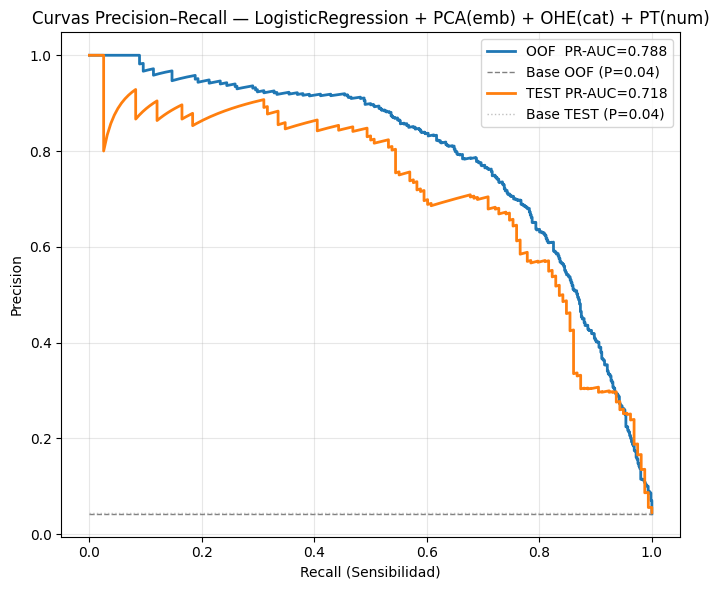

In [10]:
pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        class_weight="balanced",
        random_state=42))
])

# CV por grupos
gkf = GroupKFold(n_splits=5)
groups = df_1.loc[mask_tr, 'channel_id']


metrics = eval_pr_auc(
    pipeline_power,
    X_train, y_train,
    X_test,  y_test,
    cv=gkf, groups=groups,
    plot=True,
    title="LogisticRegression + PCA(emb) + OHE(cat) + PT(num)"
)

## 3.2.3. ÁRBOL DE DECISION 

[OOF]  PR-AUC (AP): 0.673 | auc(rec,prec): 0.685
[TEST] PR-AUC (AP): 0.670 | auc(rec,prec): 0.695


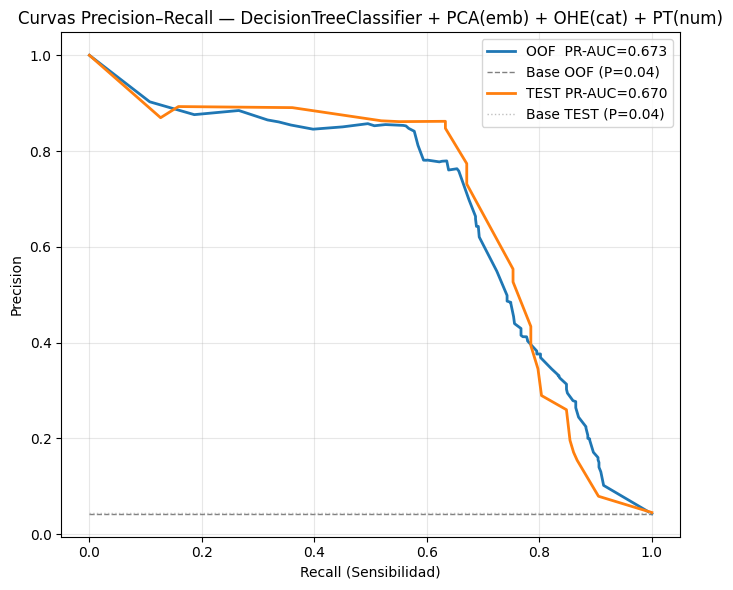

In [11]:
tree_clf = DecisionTreeClassifier(
    criterion="log_loss",        
    max_depth=6,             
    min_samples_leaf=18,     
    class_weight="balanced", 
    random_state=42
)

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', tree_clf)])

gkf = GroupKFold(n_splits=5)
groups = df_1.loc[mask_tr, 'channel_id']

metrics = eval_pr_auc(
    pipeline_power,
    X_train, y_train,
    X_test,  y_test,
    cv=gkf, groups=groups,
    plot=True,
    title="DecisionTreeClassifier + PCA(emb) + OHE(cat) + PT(num)"
)


## 3.2.4. RANDOM FORREST

[OOF]  PR-AUC (AP): 0.803 | auc(rec,prec): 0.803
[TEST] PR-AUC (AP): 0.787 | auc(rec,prec): 0.787


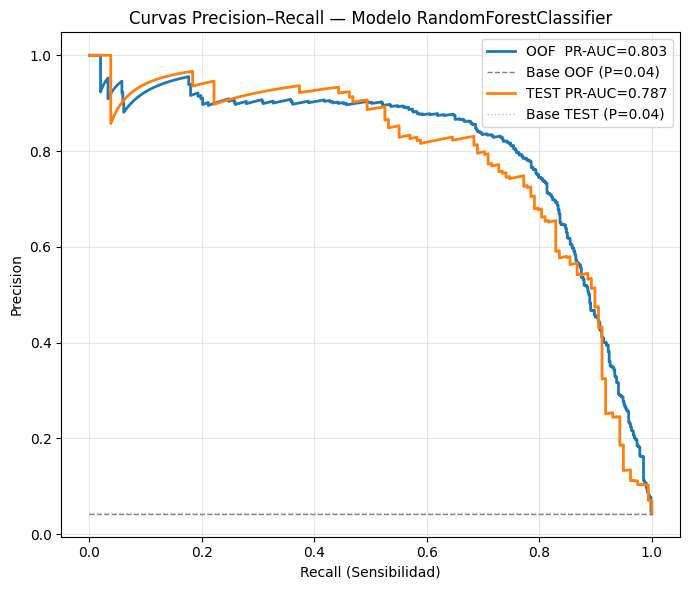

In [12]:
rf = RandomForestClassifier(random_state=42, 
                            n_estimators=400,
                            max_depth=None,
                            min_samples_leaf=2,
                            class_weight="balanced",
                            n_jobs=-1,
                         
)
                           

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', rf)
])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)



ymetrics = eval_pr_auc(
    pipeline_power,
    X_train, y_train,
    X_test, y_test,
    cv=gkf, groups=groups,
    plot=True,
    title="Modelo RandomForestClassifier"
)

## 3.2.5. XGBOOST

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__colsample_bylevel=0.7, model__colsample_bynode=0.8, model__colsample_bytree=0.6, model__gamma=0.6, model__learning_rate=0.015, model__max_depth=5, model__min_child_weight=14, model__n_estimators=1400, model__reg_alpha=1.5, model__reg_lambda=5.0, model__subsample=0.6; total time=   3.6s
[CV] END model__colsample_bylevel=0.7, model__colsample_bynode=0.8, model__colsample_bytree=0.6, model__gamma=0.6, model__learning_rate=0.015, model__max_depth=5, model__min_child_weight=14, model__n_estimators=1400, model__reg_alpha=1.5, model__reg_lambda=5.0, model__subsample=0.6; total time=   3.6s
[CV] END model__colsample_bylevel=0.7, model__colsample_bynode=0.8, model__colsample_bytree=0.6, model__gamma=0.6, model__learning_rate=0.015, model__max_depth=5, model__min_child_weight=14, model__n_estimators=1400, model__reg_alpha=1.5, model__reg_lambda=5.0, model__subsample=0.6; total time=   3.7s
[CV] END model__colsample_byl

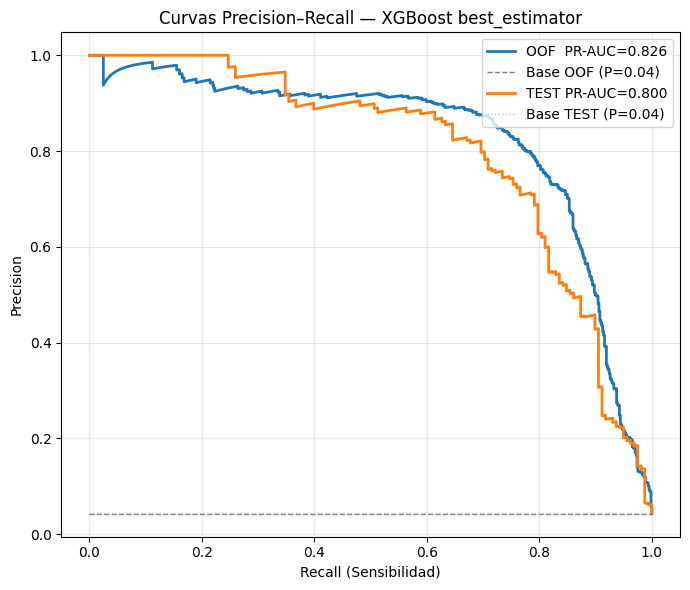

In [13]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    random_state=42,
    n_jobs=-1
)
pipeline_power = Pipeline([
    ("preprocessing", preprocessor),
    ("model", xgb_model)
])

# 2) Hiperparámetros anti-overfit (los tuyos)
param_dist_xgb_overfit = {
    "model__n_estimators":      [1200, 1400],
    "model__max_depth":         [4, 5],
    "model__min_child_weight":  [12, 14, 16],
    "model__subsample":         [0.6, 0.65, 0.7],
    "model__colsample_bytree":  [0.5, 0.55, 0.6],
    "model__colsample_bynode":  [0.6, 0.7, 0.8],
    "model__colsample_bylevel": [0.7],
    "model__gamma":             [0.6, 0.8, 1.0],
    "model__reg_alpha":         [1.5, 2.0, 3.0],
    "model__reg_lambda":        [5.0, 7.0, 9.0],
    "model__learning_rate":     [0.015, 0.02],
}

groups = df_1.loc[mask_tr, "channel_id"]
gkf = GroupKFold(n_splits=5)

xgb_search = RandomizedSearchCV(
    estimator=pipeline_power,
    param_distributions=param_dist_xgb_overfit,
    n_iter=20,
    scoring="average_precision",
    cv=gkf,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_search.fit(X_train, y_train, groups=groups)  
best_model = xgb_search.best_estimator_
ymetrics = eval_pr_auc(
    best_model,
    X_train, y_train,
    X_test, y_test,
    cv=gkf, groups=groups,
    plot=True,
    title="XGBoost best_estimator")

Matriz de confusion

In [14]:
y_proba = best_model.predict_proba(X_test)[:, 1]
thres_info = best_threshold_fbeta(y_test, y_proba, beta=0.7)  
threshold = thres_info["threshold"]

y_pred = (y_proba >= threshold).astype(int)
res = best_threshold_fbeta(y_test, y_proba, beta=0.7)
print(res)  


{'threshold': 0.3510986566543579, 'precision': 0.8208955223880597, 'recall': 0.6962025316455697, 'fbeta': 0.7752341311127178, 'beta': 0.7}


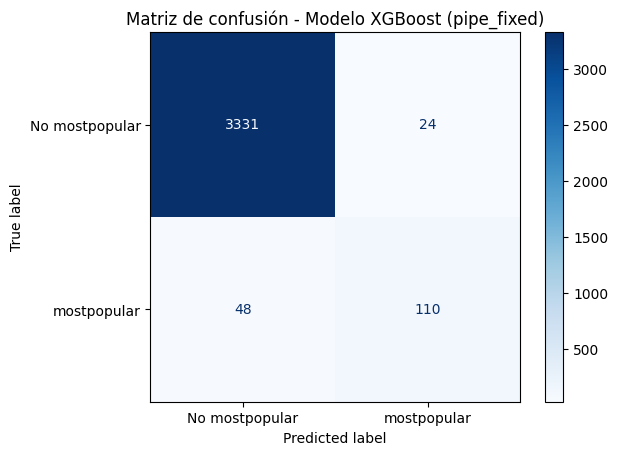

In [15]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No mostpopular", "mostpopular"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - Modelo XGBoost (pipe_fixed)")
plt.show()

In [16]:
y_proba = best_model.predict_proba(X_test)[:, 1]

# 2️⃣ Cálculo de curvas PR para encontrar el mejor umbral
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Fβ-score (puedes cambiar β = 0.7, 1.0, etc.)
beta = 0.7
fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
fbeta = np.nan_to_num(fbeta)  # limpiar NaN
best_idx = np.argmax(fbeta)
best_threshold = thresholds[best_idx]
best_fbeta = fbeta[best_idx]

# 3️⃣ Clasificación binaria usando el umbral óptimo
y_pred = (y_proba >= best_threshold).astype(int)

# 4️⃣ Métricas finales
metrics = {
    "threshold": best_threshold,
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "fbeta_score": best_fbeta,
    "beta": beta,
    "accuracy": accuracy_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
    "pr_auc": average_precision_score(y_test, y_proba),
}

# 5️⃣ Mostrar resultados ordenados
df_metrics = pd.DataFrame([metrics]).T
df_metrics.columns = ["Valor"]
print(df_metrics)

# 6️⃣ (Opcional) Mostrar resumen bonito
print(f"\n--- Resultados XGBoost (mostPopular) ---")
print(f"PR-AUC     : {metrics['pr_auc']:.3f}")
print(f"ROC-AUC    : {metrics['roc_auc']:.3f}")
print(f"Accuracy   : {metrics['accuracy']:.3f}")
print(f"F1-score   : {metrics['f1_score']:.3f}")
print(f"Fβ({metrics['beta']}) : {metrics['fbeta_score']:.3f}")
print(f"Precision  : {metrics['precision']:.3f}")
print(f"Recall     : {metrics['recall']:.3f}")
print(f"Threshold  : {metrics['threshold']:.3f}")

                Valor
threshold    0.351099
precision    0.820896
recall       0.696203
f1_score     0.753425
fbeta_score  0.775234
beta         0.700000
accuracy     0.979505
roc_auc      0.969975
pr_auc       0.799563

--- Resultados XGBoost (mostPopular) ---
PR-AUC     : 0.800
ROC-AUC    : 0.970
Accuracy   : 0.980
F1-score   : 0.753
Fβ(0.7) : 0.775
Precision  : 0.821
Recall     : 0.696
Threshold  : 0.351


### 3.1.5.1 SHAP 


X_test_df: (3513, 70) | Ejemplo cols: ['duration_minutes', 'has_caption', 'licensed_content', 'frecuencia_videos', 'definition', 'category_id_1.0', 'category_id_2.0', 'category_id_10.0']


 99%|===================| 3484/3513 [00:57<00:00]        


Top-20 |SHAP| medio
              feature  mean_abs_shap
0               emb_1       0.770582
1               emb_4       0.379688
2    duration_minutes       0.376912
3               emb_3       0.363009
4               emb_0       0.326663
5    category_id_10.0       0.271076
6               emb_2       0.261932
7   frecuencia_videos       0.249176
8              emb_21       0.194748
9              emb_16       0.187553
10             emb_32       0.186405
11             emb_23       0.185241
12             emb_47       0.185013
13             emb_11       0.181960
14              emb_7       0.164368
15   licensed_content       0.159854
16             emb_41       0.153461
17             emb_20       0.144534
18             emb_40       0.139507
19             emb_27       0.121646


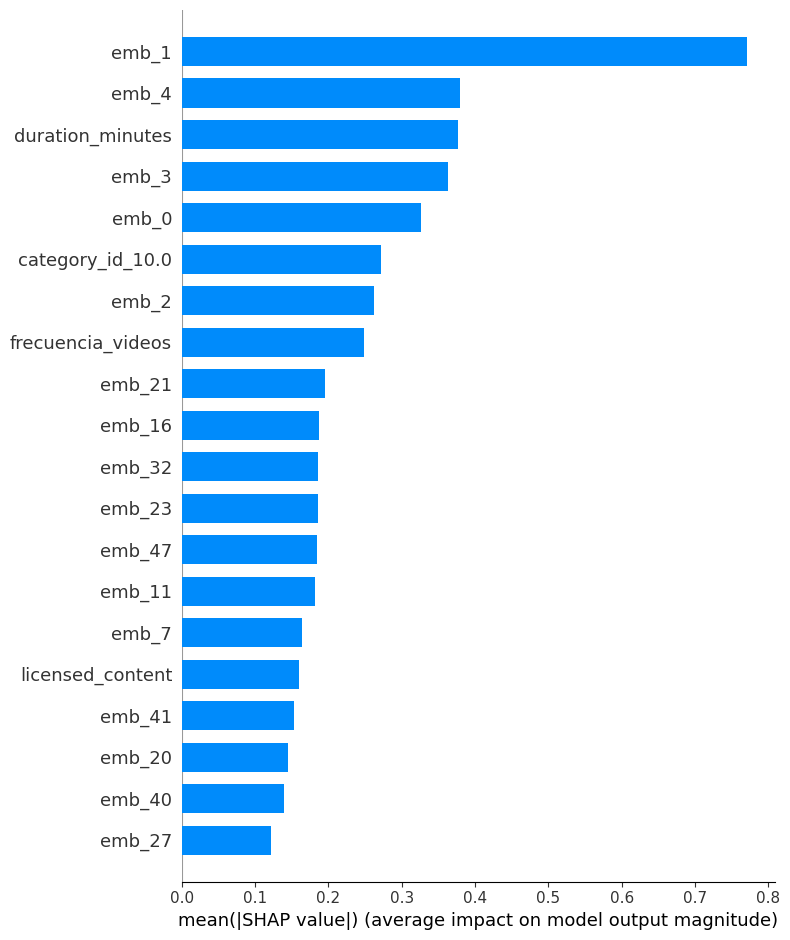

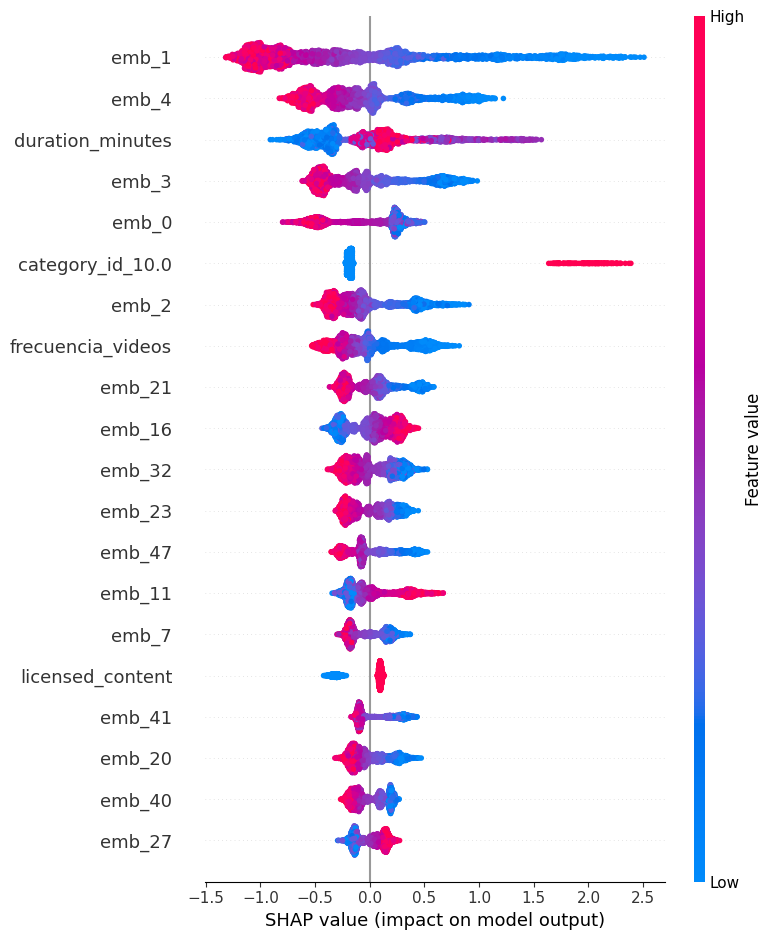

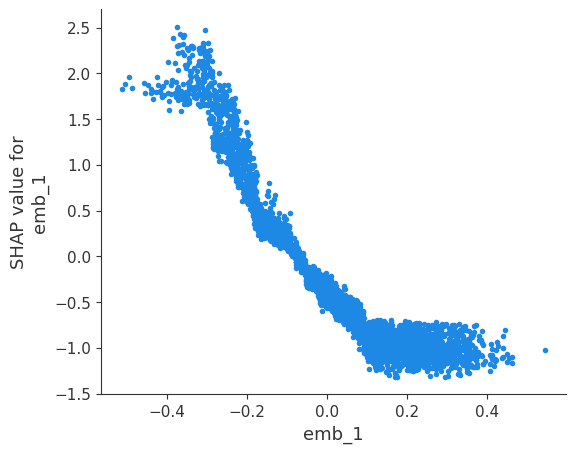

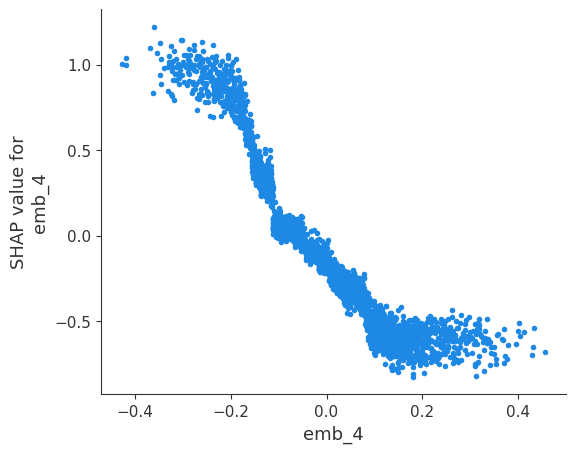

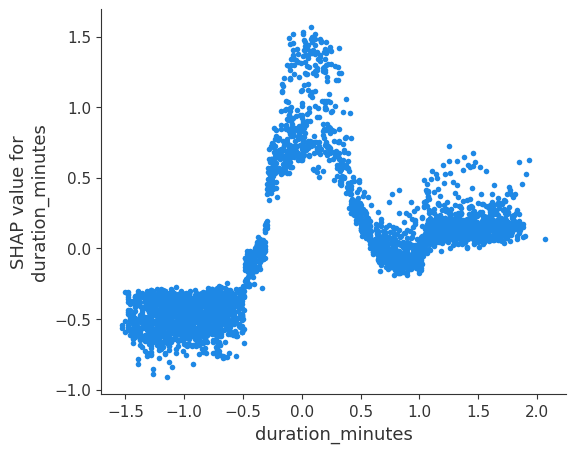

In [17]:
# Preparación de pipelines
def _resolve_cols(cols, X_sample: pd.DataFrame):
    if callable(cols):
        cols = cols(X_sample)
    if isinstance(cols, slice):
        return list(X_sample.columns[cols])
    if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
        if len(cols) > 0 and isinstance(cols[0], (int, np.integer)):
            return list(X_sample.columns[list(cols)])
        if isinstance(cols, (np.ndarray, pd.Index)) and getattr(cols, "dtype", None) == bool:
            return list(X_sample.columns[cols])
        return list(cols)
    return [cols]

def get_ct_feature_names_compat(ct, X_sample: pd.DataFrame):
    out = []
    for name, trans, cols in ct.transformers_:
        if trans == "drop":
            continue
        cols_res = _resolve_cols(cols, X_sample)

        
        if hasattr(trans, "get_feature_names_out"):
            try:
                feats = trans.get_feature_names_out(cols_res)
                out.extend(list(feats))
                continue
            except Exception:
                pass

        
        if trans == "passthrough":
            out.extend(cols_res)
            continue

     
        X_slice = X_sample[cols_res]
        try:
            Xt = trans.transform(X_slice)
        except Exception:
            n = min(50, len(X_slice))
            Xt = trans.transform(X_slice.iloc[:n])

        if sparse.issparse(Xt):
            Xt = Xt.toarray()
        else:
            Xt = np.asarray(Xt)

        n_out = Xt.shape[1] if Xt.ndim > 1 else 1
        out.extend([f"{name}_{i}" for i in range(n_out)])
    return np.array(out, dtype=object)

# Preprocesador para best_model
ct = best_model.named_steps["preprocessing"]

try:
    ct.set_output(transform="default")
except Exception:
    pass

try:
    cat_tr = ct.named_transformers_.get("cat", None)
    if cat_tr is not None and hasattr(cat_tr, "named_steps"):
        ohe = cat_tr.named_steps.get("ohe", None)
        if ohe is not None and hasattr(ohe, "set_output"):
            ohe.set_output(transform="default")
except Exception:
    pass

# Transforma X_test y construye DataFrame con nombres
X_sample = X_train.iloc[: min(100, len(X_train))].copy()
feature_names = get_ct_feature_names_compat(ct, X_sample)

Xt = ct.transform(X_test)  # puede ser sparse
if sparse.issparse(Xt):
    Xt = Xt.toarray()

X_test_df = pd.DataFrame(Xt, columns=feature_names)
print("X_test_df:", X_test_df.shape, "| Ejemplo cols:", X_test_df.columns[:8].tolist())

# Sanity check para el modelo final
xgb_final = best_model.named_steps["model"]
assert X_test_df.shape[1] == getattr(xgb_final, "n_features_in_", X_test_df.shape[1]), \
       "Dimensión de X_test_df no coincide con el modelo."


# background pequeño para estabilidad
X_bg = shap.utils.sample(X_test_df, 100, random_state=42)
explainer = shap.TreeExplainer(xgb_final, data=X_bg, feature_perturbation="interventional")

shap_vals = explainer.shap_values(X_test_df)

# normaliza salida (según versión de shap)
if isinstance(shap_vals, list):
    # binaria: suele venir [neg, pos]; nos quedamos con la clase positiva
    shap_matrix = shap_vals[-1]
elif hasattr(shap_vals, "values"):
    shap_matrix = shap_vals.values
else:
    shap_matrix = np.asarray(shap_vals)

# TOP-20 SHAP
mean_abs_shap = np.abs(shap_matrix).mean(axis=0)
top_idx = np.argsort(-mean_abs_shap)[:20]
top_features = (pd.DataFrame({
    "feature": X_test_df.columns[top_idx],
    "mean_abs_shap": mean_abs_shap[top_idx]
})
.sort_values("mean_abs_shap", ascending=False)
.reset_index(drop=True))

print("\nTop-20 |SHAP| medio")
print(top_features)

# Plots
shap.summary_plot(shap_matrix, X_test_df, plot_type="bar", max_display=20)
shap.summary_plot(shap_matrix, X_test_df, max_display=20)

for feat in top_features["feature"].head(3):
    try:
        shap.dependence_plot(feat, shap_matrix, X_test_df, interaction_index=None)
    except Exception as e:
        print(f"Dependence plot falló para {feat}: {e}")

## 3.2.6. RED NEURONAL

[OOF]  PR-AUC (AP): 0.828 | auc(rec,prec): 0.828
[TEST] PR-AUC (AP): 0.791 | auc(rec,prec): 0.791


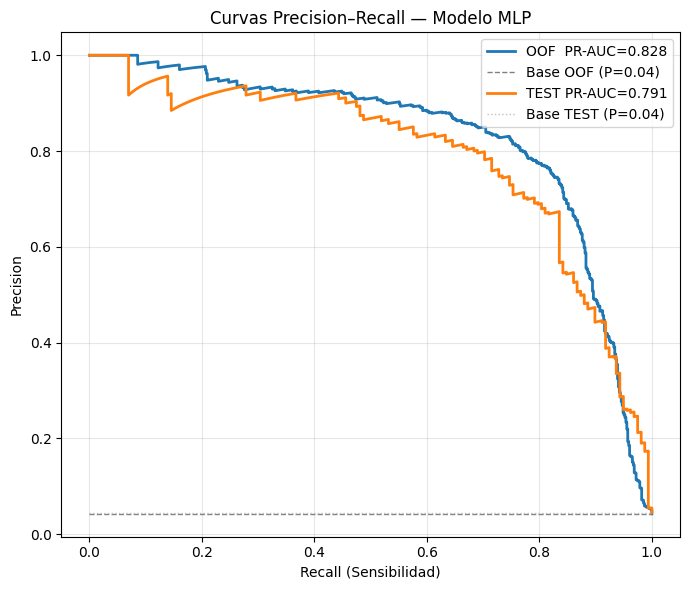

In [18]:

mlp = MLPClassifier(
    hidden_layer_sizes=(128,64),   
    activation="relu",
    solver="adam",
    alpha=1e-4,                     
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.2,
    random_state=42,
    verbose=False
)


pipeline_power = Pipeline(
    steps=[
    ('preprocessing', preprocessor),
    ('model', mlp),
])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)


ymetrics = eval_pr_auc(
    pipeline_power,
    X_train, y_train,
    X_test, y_test,
    cv=gkf, groups=groups,
    plot=True,
    title="Modelo MLP")


## 3.1.7 Análisis de variables

In [19]:
df_2=pd.read_parquet("../DATA/PROCESSED/df_TFMYouTube_embeddings_UMAP5_CLUSTERS_UMAP2.parquet")
df_1[["umap2_x", "umap2_y","cluster_umap5", "views", "likes", "comments", "engagement_rate",]] = df_2[["umap2_x", "umap2_y","cluster_umap5", "views", "likes", "comments", "engagement_rate"]]

best_pipe = xgb_search.best_estimator_  # o joblib.load("models/mostpopular/artifacts/model.joblib")

# Localiza el PCA que procesa 'embedding_joint' dentro del preprocessor
pre = best_pipe.named_steps["preprocessing"]

# Ajuste de nombres a configuración real
pca = pre.named_transformers_["emb"].named_steps["pca"]   # e.g. Pipeline([("scaler", ...), ("pca", PCA(...))])

# Prepara la matriz a partir de la columna 'embedding_joint'
def to_vec(x):
    # x puede venir como lista, np.array o string de lista -> normalízalo
    if isinstance(x, str):
        import ast
        return np.array(ast.literal_eval(x), dtype=float)
    return np.array(x, dtype=float)

E = np.vstack(df_1["embedding_joint"].apply(to_vec).values)  # shape: (n_samples, d)

# Transforma con el PCA ya entrenado
Z = pca.transform(E)  # shape: (n_samples, n_components)

# Vuelca a columnas emb_1..emb_k
k = Z.shape[1]
emb_cols = [f"emb_{i+1}" for i in range(k)]
df_1[emb_cols] = Z

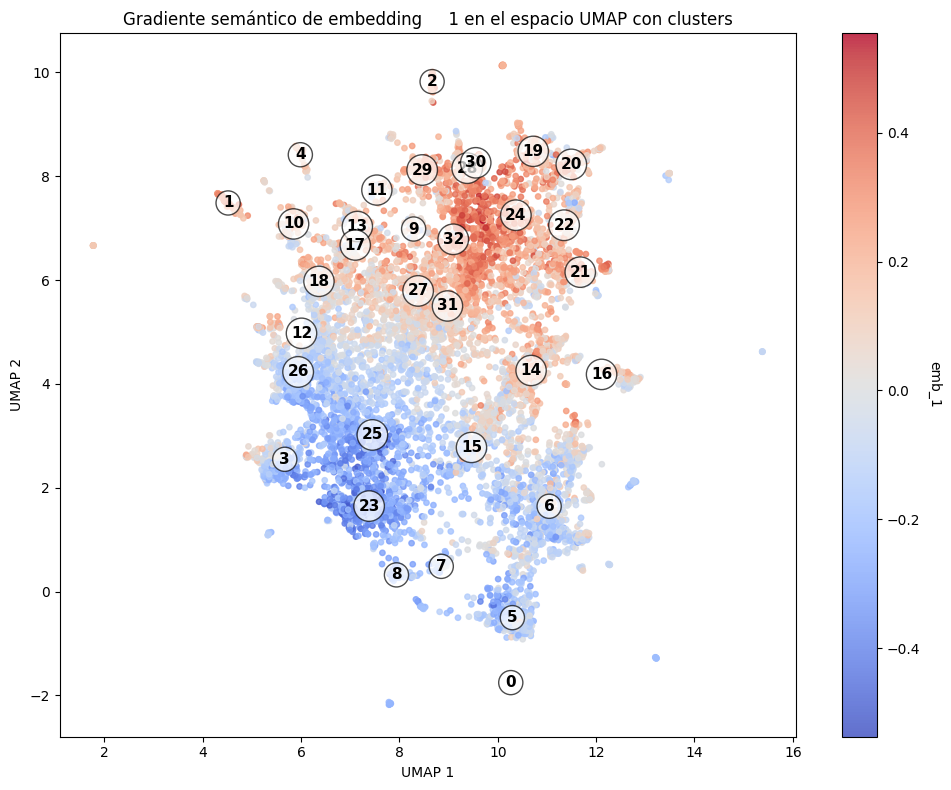

In [20]:
df_plot = df_1.sample(min(8000, len(df_1)), random_state=42)

plt.figure(figsize=(10, 8))

# Puntos coloreados por emb_10
sc = plt.scatter(
    df_plot["umap2_x"], df_plot["umap2_y"],
    c=df_plot["emb_1"], cmap="coolwarm", s=15, alpha=0.8
)

# Colorbar continua
cbar = plt.colorbar(sc)
cbar.set_label("emb_1", rotation=270, labelpad=15)

# Añade los números de los clusters
centroids = (
    df_1[df_1["cluster_umap5"] != -1]  # excluye ruido
    .groupby("cluster_umap5")[["umap2_x", "umap2_y"]]
    .mean()
    .reset_index()
)

for _, row in centroids.iterrows():
    plt.text(
        row["umap2_x"], row["umap2_y"],
        str(int(row["cluster_umap5"])),
        fontsize=11, fontweight="bold",
        ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="black", alpha=0.7, boxstyle="circle,pad=0.3")
    )


plt.title("Gradiente semántico de embedding     1 en el espacio UMAP con clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

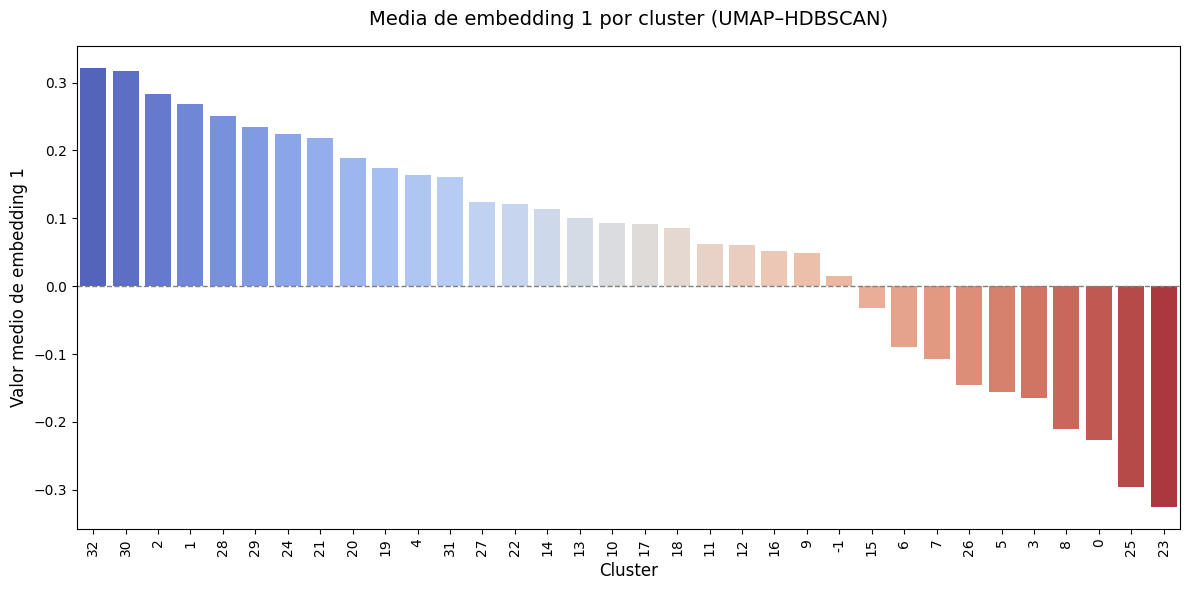

In [21]:
# Calcular la media del embedding 1 por cluster y ordenarla de mayor a menor
mean_emb1 = (
    df_1.groupby("cluster_umap5")["emb_1"]
        .mean()
        .sort_values(ascending=False)
)

# Graficar en el orden correcto
plt.figure(figsize=(12, 6))
sns.barplot(
    x=mean_emb1.index.astype(str),  # convertir a string para evitar errores con el orden
    y=mean_emb1.values,
    palette="coolwarm",
    order=mean_emb1.index.astype(str)  # mantener el orden de mayor a menor
)

# Línea base y etiquetas
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Media de embedding 1 por cluster (UMAP–HDBSCAN)", fontsize=14, pad=15)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Valor medio de embedding 1", fontsize=12)

# Rotación de etiquetas
plt.xticks(rotation=90, ha="center")

plt.tight_layout()
plt.show()

In [22]:
df_1.groupby("cluster_umap5")["emb_1"].mean().sort_values()


cluster_umap5
 23   -0.325389
 25   -0.295495
 0    -0.227208
 8    -0.210377
 3    -0.164114
 5    -0.155479
 26   -0.145582
 7    -0.107296
 6    -0.089381
 15   -0.031729
-1     0.015287
 9     0.048598
 16    0.052029
 12    0.061305
 11    0.062283
 18    0.086108
 17    0.092162
 10    0.093776
 13    0.099795
 14    0.114085
 22    0.120652
 27    0.124609
 31    0.160834
 4     0.163262
 19    0.174559
 20    0.188817
 21    0.218965
 24    0.223855
 29    0.234678
 28    0.250933
 1     0.268477
 2     0.283127
 30    0.317173
 32    0.321717
Name: emb_1, dtype: float64

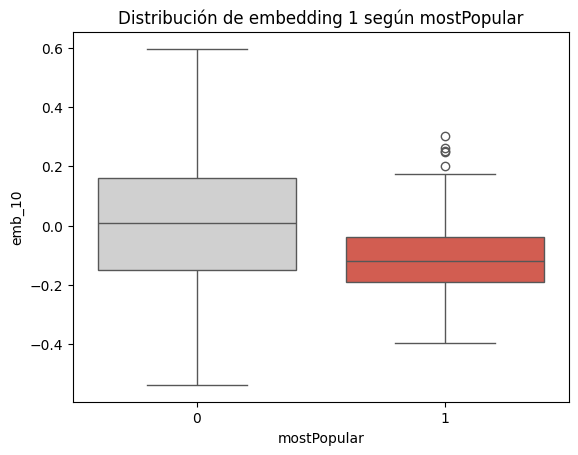

In [23]:
sns.boxplot(data=df_1, x="mostpopular", y="emb_1", palette=["#d0d0d0","#e74c3c"])
plt.title("Distribución de embedding 1 según mostPopular"); plt.xlabel("mostPopular"); plt.ylabel("emb_10")
plt.show()

<Axes: >

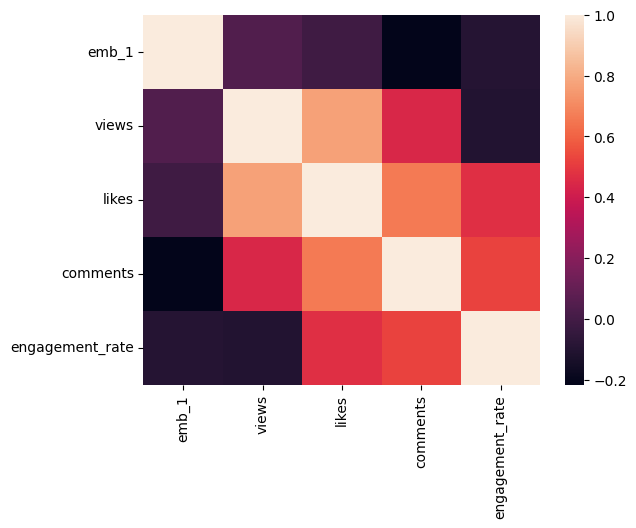

In [24]:
corr=df_1[["emb_1", "views", "likes", "comments", "engagement_rate"]].corr(method="spearman")
sns.heatmap(corr)

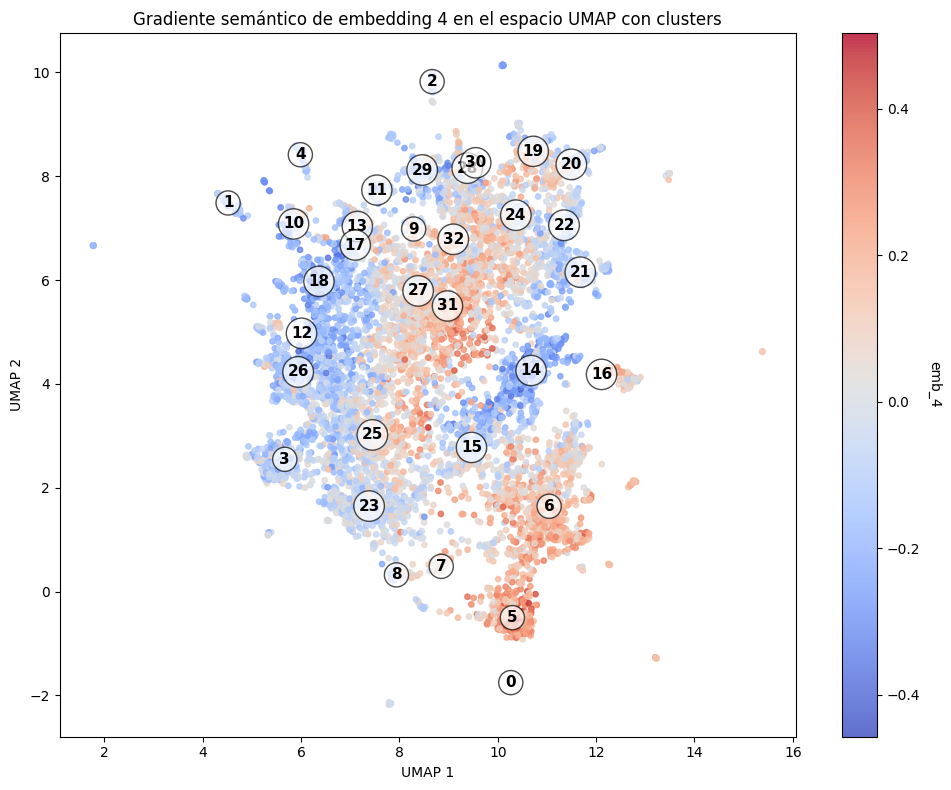

In [25]:
df_plot = df_1.sample(min(8000, len(df_1)), random_state=42)

plt.figure(figsize=(10, 8))


sc = plt.scatter(
    df_plot["umap2_x"], df_plot["umap2_y"],
    c=df_plot["emb_4"], cmap="coolwarm", s=15, alpha=0.8
)

cbar = plt.colorbar(sc)
cbar.set_label("emb_4", rotation=270, labelpad=15)

centroids = (
    df_1[df_1["cluster_umap5"] != -1]  # excluye ruido
    .groupby("cluster_umap5")[["umap2_x", "umap2_y"]]
    .mean()
    .reset_index()
)

for _, row in centroids.iterrows():
    plt.text(
        row["umap2_x"], row["umap2_y"],
        str(int(row["cluster_umap5"])),
        fontsize=11, fontweight="bold",
        ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="black", alpha=0.7, boxstyle="circle,pad=0.3")
    )


plt.title("Gradiente semántico de embedding 4 en el espacio UMAP con clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

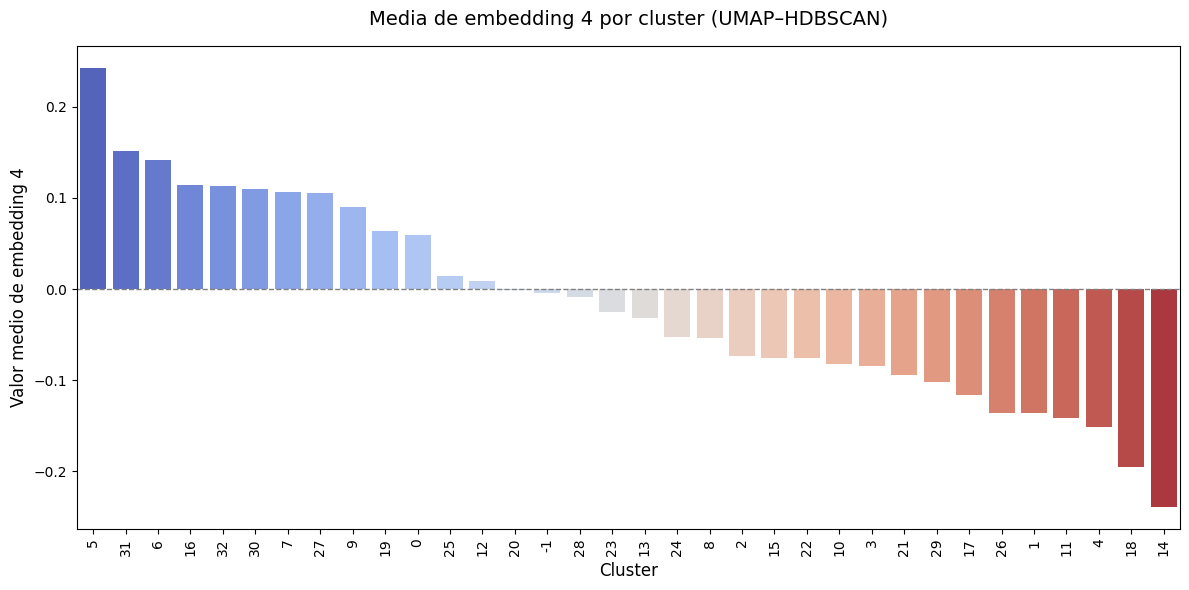

In [26]:
# Calcular la media del embedding 1 por cluster y ordenarla de mayor a menor
mean_emb4 = (
    df_1.groupby("cluster_umap5")["emb_4"]
        .mean()
        .sort_values(ascending=False)
)

# Graficar en el orden correcto
plt.figure(figsize=(12, 6))
sns.barplot(
    x=mean_emb4.index.astype(str),  # convertir a string para evitar errores con el orden
    y=mean_emb4.values,
    palette="coolwarm",
    order=mean_emb4.index.astype(str)  # mantener el orden de mayor a menor
)

# Línea base y etiquetas
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Media de embedding 4 por cluster (UMAP–HDBSCAN)", fontsize=14, pad=15)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Valor medio de embedding 4", fontsize=12)

# Rotación de etiquetas
plt.xticks(rotation=90, ha="center")

plt.tight_layout()
plt.show()

In [27]:
df_1.groupby("cluster_umap5")["emb_4"].mean().sort_values()


cluster_umap5
 14   -0.239130
 18   -0.194780
 4    -0.151335
 11   -0.140955
 1    -0.135851
 26   -0.135762
 17   -0.116050
 29   -0.102060
 21   -0.093889
 3    -0.084378
 10   -0.082710
 22   -0.075847
 15   -0.075787
 2    -0.073405
 8    -0.054257
 24   -0.052795
 13   -0.031575
 23   -0.024812
 28   -0.008303
-1    -0.004125
 20   -0.000840
 12    0.009329
 25    0.014650
 0     0.059148
 19    0.063152
 9     0.089520
 27    0.104907
 7     0.106626
 30    0.109591
 32    0.112904
 16    0.113710
 6     0.141144
 31    0.151627
 5     0.242720
Name: emb_4, dtype: float64

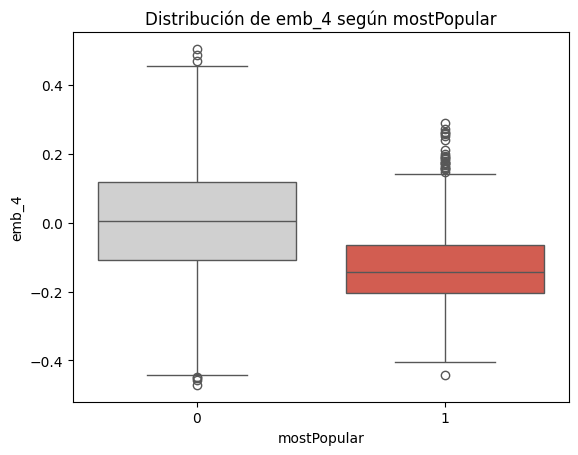

In [28]:
sns.boxplot(data=df_1, x="mostpopular", y="emb_4", palette=["#d0d0d0","#e74c3c"])
plt.title("Distribución de emb_4 según mostPopular"); plt.xlabel("mostPopular"); plt.ylabel("emb_4")
plt.show()

<Axes: >

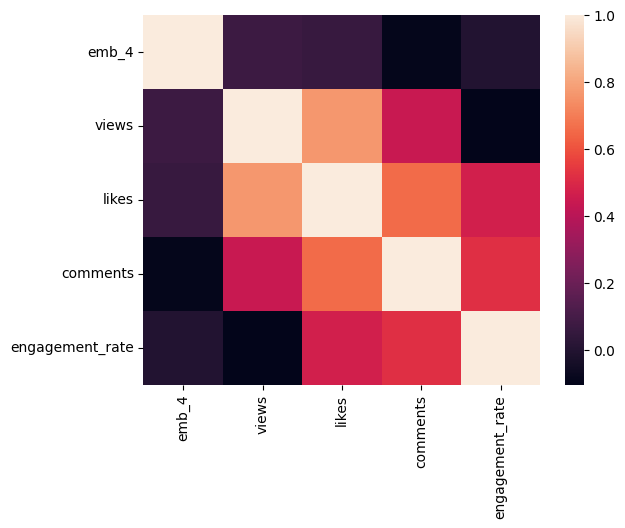

In [29]:
corr=df_1[["emb_4", "views", "likes", "comments", "engagement_rate"]].corr(method="spearman")
sns.heatmap(corr)